<a href="https://colab.research.google.com/github/lexcrist/chem_compound_identification/blob/main/Compound_Identification_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Author: Lex C. Crist
* Email: acc297@cornell.edu
* Course: CHEM 3020 Fall 2022, Prof. Marohn
* Short summary: Reading in files from UV-Vis Spectroscopy, FTIR Spectroscopy and inputting data from the Fluorimeter in order to determine the identities of unknown compounds and create calibration curves to determine the concentration of compounds with unknown concentrations.
* Note: Some code was based off of notebooks shared in `CHEM-3020-FA-2022--shared`

# Preliminaries

## Mounting Drive and Importing Modules

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 6.50, 4.00

In [ ]:
import pandas as pd
import plotly.express as px
from collections import OrderedDict

In [ ]:
import math

In [ ]:
from bs4 import BeautifulSoup as bs
import lxml
import os
import re
import numpy as np
from operator import getitem

In [ ]:
! pip install lmfit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from lmfit import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
FOLDER = '/content/drive/My Drive/CHEM-3020-FA-2022--acc297/EX10/'

In [ ]:
ls '/content/drive/My Drive/CHEM-3020-FA-2022--acc297/EX10/'

 CHEM-3020-FA-2022--Final-Exam-Workup--acc297.ipynb   FTIR_Final/
'Film View 1_Corrected.JDX'                           UV_Vis_Final/


## Creating Data Classes:

A line `Model` was used to create the calibration curves:

In [ ]:
def line(x, m, b):
    return m*x + b

In [ ]:
  ### get_details() takes the ModelResult of a line fit, prints out the
  ### details of the fit parameters and returns the parameter values and
  ### standard errors
def get_details(result):
    m = result.params['m'].value
    b = result.params['b'].value
    m_std = result.params['m'].stderr
    b_std = result.params['b'].stderr
    print("The slope of the calibration curve is {:.4f} +/- {:.4f} [A/mM]".format(m, m_std))
    print("The y-int of the calibration curve is {:.4f} +/- {:.4f} [A]".format(b, b_std))
    return m, m_std, b, b_std

A `BeersDataSet Class` was created for EX09 to analyze UV-Vis data, this class is inputted and adjusted for this experiment:

In [ ]:
class BeersDataSet:

  def __init__(self, FOLDER, conc_known_str, unk_dils):
    self.files = []
    self.concs = []
    self.unknown_dilutions = []
    self.knowndata = {}
    self.unknowndata = {}
    known_data_unadjusted = {}
    for i in range(len(conc_known_str)):
      filename = 'Known_' + conc_known_str[i] + '_1.CSV'
      conc = float(conc_known_str[i])/1000
      self.concs.append(conc)
      self.files.append(filename)
      known_data_unadjusted[conc] = pd.read_csv(FOLDER + filename, encoding = 'UTF-16')
      indices = [x for x in range(0,401)]
      self.knowndata[conc] = known_data_unadjusted[conc][210:611]
      self.knowndata[conc].index = indices

    unknown_data_unadjusted = {}
    for i in range(len(unk_dils)):
      dil_ratio = float(unk_dils[i])/100
      num = str(i+1)
      filename = "Unknown_" + unk_dils[i] + "_" + num
      self.files.append(filename)
      unknown_data_unadjusted[filename] = pd.read_csv(FOLDER + filename + ".CSV", encoding = 'UTF-16')
      indices = [x for x in range(0,401)]
      self.unknowndata[filename] = unknown_data_unadjusted[filename][210:611]
      self.unknowndata[filename].index = indices
      self.unknown_dilutions.append(dil_ratio)

  # A series of functions to analyze whether a dataset obeys Beer's Law are
  # added to this class:

  ### The beers_find_wavelength() function evaluates the max abs values of the
  ### dataset and indexes them to find the wavelengths at which the max abs
  ### values occur. The rounded mean of these wavelengths is found and is used
  ### for the analysis. The index of the analysis wavelength is returned.
  def beers_find_wavelength(self, datarange = (400,800)):
    max_wavelengths = []
    start_i = datarange[0] - 400
    end_i = datarange[1] - 400 + 1
    for conc in self.concs:
      check = self.knowndata[conc]['Absorbance (AU)'][start_i:end_i]
      max_val = max(check)
      i = list(check).index(max_val) + start_i
      id_wavelength = self.knowndata[conc]['Wavelength (nm)'][i]
      max_wavelengths.append(id_wavelength)
    mean_wl = np.mean(max_wavelengths)
    wl_use = round(mean_wl)
    return wl_use

  def beers_find_index(self,datarange = (400,800)):
    tup = (datarange[0],datarange[1])
    wl_use = self.beers_find_wavelength(datarange = tup)
    i_wl = list(self.knowndata[self.concs[0]]['Wavelength (nm)']).index(wl_use)
    return i_wl

  ### The beers_absorbance() function takes the wavelength index from the
  ### beers_find_index() function and finds the absorbance values 2 above and 2
  ### below this value for each of the concentrations. The averages of these
  ### 5 absorbance values is taken and the standard deviation in these abs
  ### values is found. Returns the avg absorbance and corresponding sd values.
  def beers_absorbance(self, datarange = (400,800), override = []):
    to_use = self.concs if len(override)==0 else override
    tup = (datarange[0], datarange[1])
    avg_absorbance = []
    sd_abs = []
    wl_index = self.beers_find_index(datarange = tup)
    start = wl_index - 2
    end = wl_index + 3
    for conc in to_use:
      abs_range = self.knowndata[conc]['Absorbance (AU)'][start:end]
      mean_abs = np.mean(abs_range)
      sd = np.mean(self.knowndata[conc]['Std.Dev.'][start:end])
      avg_absorbance.append(mean_abs)
      sd_abs.append(sd)
    sigma = (np.sum(sd_abs))/len(sd_abs)
    sd_fit = sigma/np.sqrt(end-start)
    return avg_absorbance, sd_fit

  ### beers_weight() defines and returns a list of weights to fit the abs data
  def beers_weight(self, override = []):
    to_use = self.concs if len(override)==0 else override
    avg, sd_fit = self.beers_absorbance()
    w = np.ones(len(override))/sd_fit

  ### beerslaw_result takes the average absorbances and the concentrations of
  ### the dataset and fits a line to the abs vs conc data. Returns a ModelResult
  ### object describing the fit.
  def beerslaw_result(self, datarange = (400,800), override = []):
    overridelist = override
    to_use = self.concs if len(override)==0 else override
    tup = (datarange[0], datarange[1])
    avg_abs, sd = self.beers_absorbance(datarange = tup,override = overridelist)
    w = self.beers_weight(override = overridelist)
    y = avg_abs
    model = Model(line)
    result = model.fit(y, x = to_use, weights = w, m = 0., b = 0.)
    return result

  ### beerslaw_plot plots the ModelResult object fitting.
  def beerslaw_plot(self, result):
    curve = result.plot(xlabel = 'Concentrations [mM]', ylabel = 'Absorbance [a.u.]', title = 'UV-Vis' + " Calibration Curve")
    return curve

  ### beerslaw() combines the above evaluated functions and returns the
  ### ModelResult object that describes the fit, and shows the plot of the fit
  ### model.
  def beerslaw(self, datarange = (400,800), override = []):
    overridelist = override
    tup = (datarange[0],datarange[1])
    result = self.beerslaw_result(datarange=tup, override = overridelist)
    print(result)
    self.beerslaw_plot(result)
    return result

  ### find_unknown() takes the fit information from the ModelResult object of
  ### the beerslaw() fit to find the concentration of the unknown after
  ### loading the unknown data from the unk_file filename
  def find_unknown_conc(self, result, datarange = (400,800), exclude = 'Unknown_100_1'):
    dil_concs = []
    concs = []
    m, m_std, b, b_std = get_details(result)
    keylist = list(self.unknowndata.keys())
    for key in keylist[0:6]:
      abs = max(self.unknowndata[key]["Absorbance (AU)"])
      dil_conc = (abs)/m
      dil_ratio = float(key[8:11])/100
      conc = dil_conc/dil_ratio
      concs.append(conc)
      dil_concs.append(dil_conc)
    return dil_concs, concs

  ### The adjust_baseline() function takes the data and adjusts the baseline to
  ### 0. To do this, the absorbances above 775nm are averaged to create the
  ### difference between the baseline and 0. This 775-800nm range is used as it
  ### does not have any peaks for any of the 5 individual dyes or the universal
  ### indicator.
  def adjust_baseline(self):
    known = self.knowndata
    unknown = self.unknowndata
    for key in self.knowndata.keys():
      x = self.knowndata[key]["Wavelength (nm)"]
      y = list(self.knowndata[key]["Absorbance (AU)"])
      diff = np.mean(y[len(y)-100:len(y)-1])
      for i in range(len(y)):
        y[i] = y[i] - diff
      self.knowndata[key]["Absorbance (AU)"] = y
    for key in self.unknowndata.keys():
      x = self.unknowndata[key]["Wavelength (nm)"]
      y = list(self.unknowndata[key]["Absorbance (AU)"])
      diff = np.mean(y[len(y)-100:len(y)-1])
      for i in range(len(y)):
        y[i] = y[i] - diff
      self.unknowndata[key]["Absorbance (AU)"] = y

  def plotall(self, datakey, plotrange = (400,800)):
    if datakey == 'Known':
      data = self.knowndata
      pltlabel_add = " mM"
      title = 'Spectra of Colored Solute of Known Concentrations:'
    else:
      data = self.unknowndata
      pltlabel_add = " % dilution"
      title = 'Spectra of Colored Solute of Unknown Concentration at Various Dilutions:'
    keylist = list(data.keys())
    length = len(keylist)
    max_per_row = 7
    num_plots = len(keylist)
    fig, ax = plt.subplots(1, num_plots, sharex=True, sharey=True, figsize = (24, length*3))
    for val in range(0,length):
      key = keylist[val]
      x = data[key]['Wavelength (nm)']
      y = data[key]['Absorbance (AU)']
      row_num = val // max_per_row
      col_num = val % max_per_row
      if datakey == "Unknown":
        key = int(key[8:11])
      pltlabel = str(key) + pltlabel_add
      ax[col_num].plot(x, y, label = pltlabel)
      ax[col_num].set_ylabel('Absorbance [a.u.]')
      ax[col_num].set_xlabel('Wavelength [nm]')
      ax[col_num].legend()
    print(title)
    plt.show()

  def plotone(self, datakey, plotkey):
    if datakey == 'Known':
      data = self.knowndata[plotkey]
    else:
      data = self.unknowndata[plotkey]
    x = data['Wavelength (nm)']
    y = data['Absorbance (AU)']
    plt.plot(x, y, label = plotkey)

A `FluorimetryData class` is created to load and analyze the fluorescence data collected from the fluorimeter. The data is inputted directly from the data recorded in the lab notebook.

In [ ]:
class FluorimetryData:

    ### Initializing this data class requires a list of the known concentrations
    ### measured `known_concs`, their corresponding fluorescences `known_fluors`
    ### in respective order, the list of dilutions `unknown_dils` used to
    ### measure the unknown sample and the resulting fluorescences of the
    ### unknown sample `unknown_fluors`.
    def __init__(self, known_concs, known_fluors, unknown_dils, unknown_fluors):
      self.knowndf = pd.DataFrame()
      self.knowndf["Concentration (ppm)"] = known_concs
      self.knowndf["Fluorescence"] = known_fluors
      self.unknowndf = pd.DataFrame()
      self.unknowndf["Dilution Ratio"] = unknown_dils
      self.unknowndf["Fluorescence"] = unknown_fluors

    ### fluor_result() takes the data from the knowndf columns in order to fit
    ### the concentration vs fluorescence data to a line. The ModelResult of the
    ### Model fit is returned
    def fluor_result(self, override = {}):
      if len(override) == 0:
        to_use_conc = self.knowndf["Concentration (ppm)"]
        to_use_fluor = self.knowndf["Fluorescence"]
      else:
        to_use_conc = override["Concentration (ppm)"]
        to_use_fluor = override["Fluorescence"]
      w = np.ones(len(to_use_conc))
      model = Model(line)
      result = model.fit(to_use_fluor, x = to_use_conc, weights = w, m = 0., b = 0.)
      result.plot(xlabel = 'Concentrations (ppm)', ylabel = 'Fluorescence', title = 'Fluorimetry' + " Calibration Curve")
      return result

    ### find_unknown uses the information from the ModelResult fit found from
    ### fluor_result() and inputted as `result` in order to calculate the mean
    ### and standard deviation in the calculated concentrations of the unknown.
    def find_unknown(self, result):
      m, m_std, b, b_std = get_details(result)
      dil_concs = []
      concs = []
      for i in range(len(self.unknowndf["Fluorescence"])):
        F = self.unknowndf["Fluorescence"][i]
        dil = self.unknowndf["Dilution Ratio"][i]
        dil_conc = (F - b) / m
        conc = dil_conc/dil
        dil_concs.append(dil_conc)
        concs.append(conc)
      mean_conc = np.mean(concs)
      sd_conc = np.std(concs)
      print("The mean concentration for the unknown was {:0.4f} +/- {:0.4f} ppm".format(mean_conc,sd_conc))
      return mean_conc, sd_conc

The following `InfraredData class` is used to analyze the FTIR data and is taken from `CHEM-3020-FA-2022--EX05-Workup-1.ipynb`, authored by John A. Marohn:

In [ ]:
class InfraredData:
    """Read and plot infrared absorbance data.

    Example usage:

        IRdata = InfraredData()
        IRdata.read_csv('EX06--example-data/unknown.csv')
        IRdata.scrub()
        IRdata.baseline_correct()
        IRdata.write_jdx('EX06--example-data/unknown_scrubbed.jdx')
        IRdata.plot()
    """

    def read_csv(self, filename, message = None):
        """Read infrared spectrum from csv file.

        Parameters:
        - filename: full file path string
        - message: optional message string

        Assume that the csv file has (1) no column headings and
        (2) that second column is absorbance, not tranmittance,
        data."""
        if 'Transmittance' in filename:
          self.format = '% Transmittance'
        else:
          self.format = 'Absorbance [a.u.]'
        self.df = pd.read_csv(filename, header=None,
            names=['frequency [cm^-1]', self.format])
        self.x = self.df['frequency [cm^-1]']
        self.y = self.df[self.format]
        # Save the name of the csv file plus an optional
        # message string

        if message is not None:
            self.filename_input = filename.split('/')[-1] + ' (' + message + ')'
        else:
            self.filename_input = filename.split('/')[-1]

    def plot(self):
        """Graph the infrared absorbance spectrum in an interactive plot."""
        fig = px.line(self.df,
            x = 'frequency [cm^-1]',
            y = self.format,
            title = self.filename_input)
        fig.update_xaxes(autorange="reversed")
        fig.show()

    def scrub(self):
        """Remove zeros from the y-axis data."""

        self.filename_input = self.filename_input + ', zeros removed'
        self.df = self.df[self.df['absorbance [a.u.]'] != 0]

    def baseline_correct(self):
        """Baseline correct the absorbance data by subtrating the
        minimum absorbance.  The corrected data will have at least one
        point in the spectrum with zero absorbance."""
        self.filename_input = self.filename_input + ', baseline corrected'
        if self.format == 'Absorbance [a.u.]':
          self.df['Absorbance [a.u.]'] = \
              self.df['Absorbance [a.u.]'] - min(self.df['Absorbance [a.u.]'])
        else:
          self.df['% Transmittance]'] = \
              max(self.df['% Transmittance']) - self.df['% Transmittance']

    def write_jdx(self, filename):
        """Write the spectrum as jdx file.

        Parameters:
        - filename: full file path string

        The .jdx file format is is IUPAC standard set by the Joint
        Committee on Atomic and Molecular Physical Data (JCAMP)."""

        self.x = self.df['frequency [cm^-1]'] # pandas Series data
        self.y = self.df[self.format] # pandas Series data

        jdx_core = OrderedDict({
            'TITLE':'UNKNOWN',
            'JCAMP-DX':'4.24',
            'DATA TYPE':'INFRARED SPECTRUM',
            'CLASS':'CHEM 3020 CORNELL UNIVERSITY',
            'OWNER':'STUDENT',
            'XUNITS':'1/CM',
            'YUNITS': self.format,
            'XFACTOR':1,
            'YFACTOR':1,
            'FIRSTX':'{:0.8f}'.format(self.x.iloc[0]),
            'LASTX':'{:0.8f}'.format(self.x.iloc[-1]),
            'NPOINTS':len(self.x),
            'FIRSTY':'{:0.8f}'.format(self.y.iloc[0])
        })

        with open(filename,'w') as f:

            for key in jdx_core.keys():
                f.write("##{:}={:}\n".format(key, jdx_core[key]))
            f.write('##XYDATA=(XY)\n')
            for x_val, y_val in zip(self.x, self.y):
                f.write('{:0.8f} {:0.8f}\n'.format(x_val, y_val))
            f.write('##END=')

## Setting the Data Folders:

In [ ]:
UV_Vis_files = FOLDER + 'UV_Vis_Final/'
FTIR_files = FOLDER + 'FTIR_Final/'

# Using UV-Vis Spectroscopy to Identify the Unknown Concentration of a Colored Solute:

The UV-Vis data files are loaded into a `BeersDataSet` object in order to plot and analyze it and identify the concentration of the unknown colored solute.

In [ ]:
kn_conc_str = ['06427','12854','25708','32135','44989','57843','64270']
unk_dils = ['010','010','010','020','020','020','100']
UV_VisData = BeersDataSet(UV_Vis_files,kn_conc_str,unk_dils)

The spectra for the known colored solute are plotted, labelled with the corresponding concentration of the sample measured.

Spectra of Colored Solute of Known Concentrations:


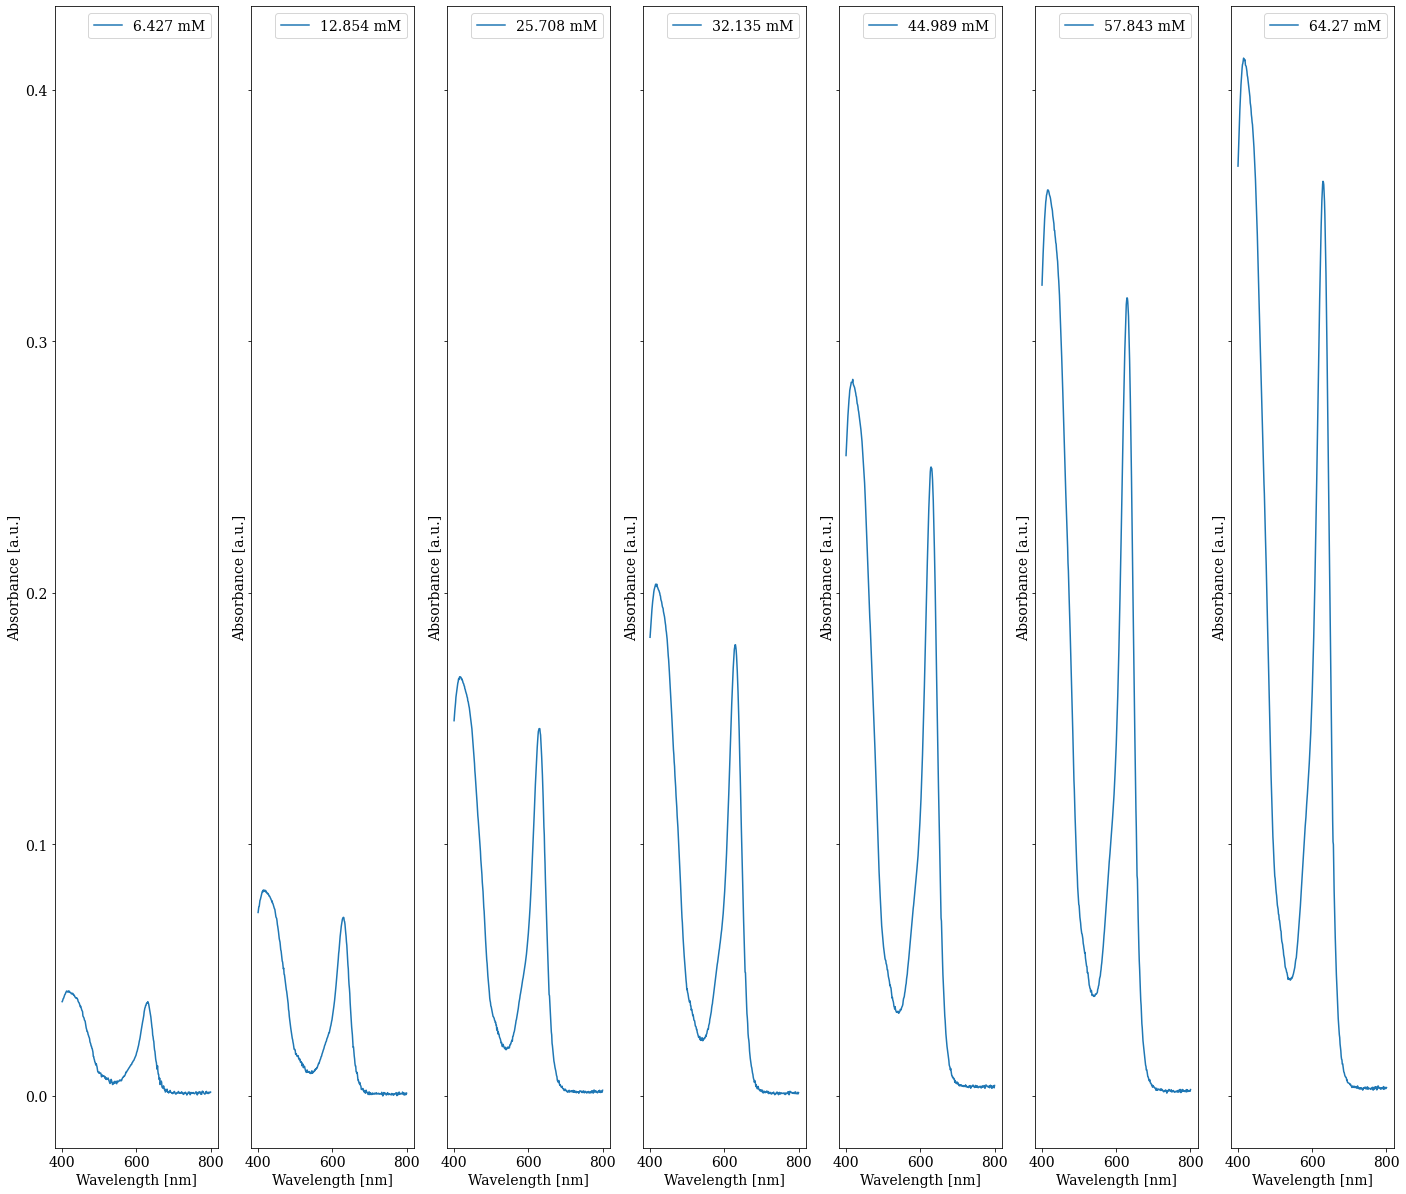

In [ ]:
UV_VisData.plotall('Known')

The UV-Vis spectra of the colored solute of unknown concentration is then plotted, labelled with the dilution percentage from the original sample with the 100% dilution referring to an undiluted sample.

Spectra of Colored Solute of Unknown Concentration at Various Dilutions:


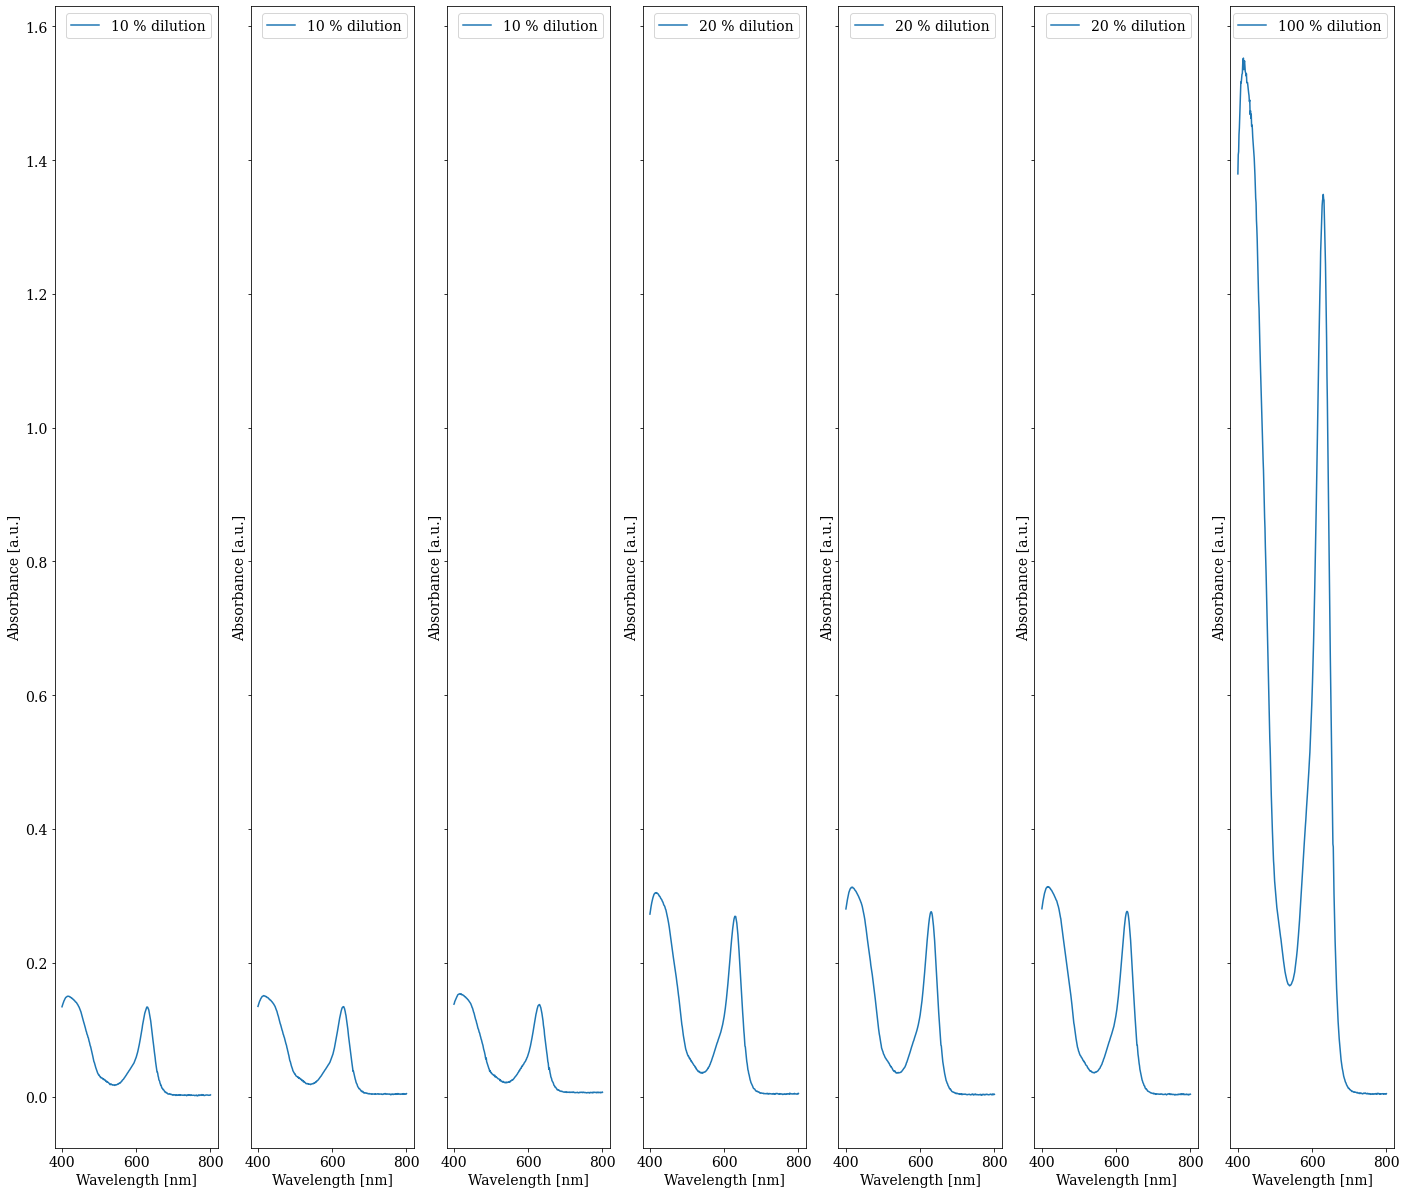

In [ ]:
UV_VisData.plotall('Unknown')

Because there are two peaks in the UV-Vis 400-800nm range for the colored solute, Beer's Law will be completed for both peaks and the graphs will be used to determine the concentration using the unknown results. The first wavelength range used is 400-550nm, a range that covers the first peak in each of the spectra for the colored solute. The peak absorbances of the colored solute of known concentration from the dilution series are used and plotted against the known concentration to fit to a line, shown below.

The wavelength used for this fit was 415 nm


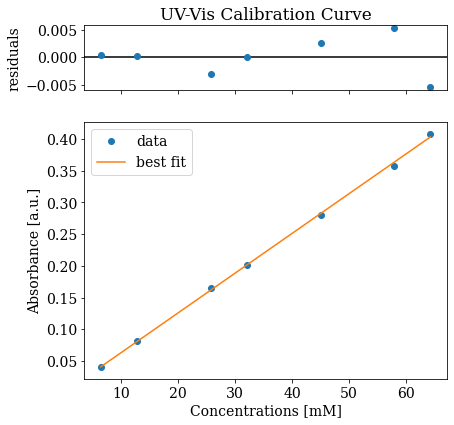

In [ ]:
UV_VisData.adjust_baseline()
print("The wavelength used for this fit was {:} nm".format(UV_VisData.beers_find_wavelength(datarange = (400,550))))
UV_result1 = UV_VisData.beerslaw(datarange = (400,550))
display(UV_result1)

While the fit looks very promising, it is important to note that the magnitude of some of the residuals is fairly large (on the order of $5*10^{-3}$) in comparison to the magnitude of the slope, $6.263*10^{-3}$. The least deviating points are then used to refit the model.

The wavelength used for this fit was 415 nm


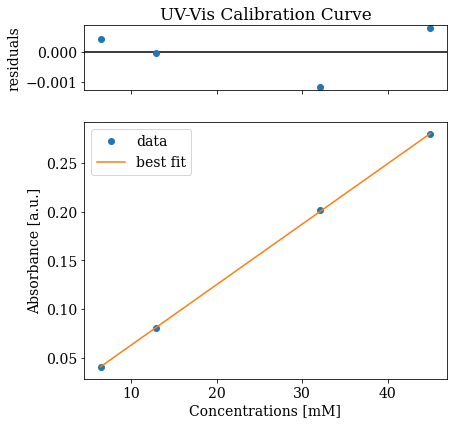

In [ ]:
print("The wavelength used for this fit was {:} nm".format(UV_VisData.beers_find_wavelength(datarange = (400,550))))
UV_result1 = UV_VisData.beerslaw(datarange = (400,550), override = [6.427,12.854,32.135,44.989])
display(UV_result1)

This fit seems better than the first, with a low chi-square value and lower residuals than the first fit, so this fit is used to calculate the concentration of the unknown colored solute.

Another fit is attempted for the second peak of the spectra:

The wavelength used for this fit was 630 nm


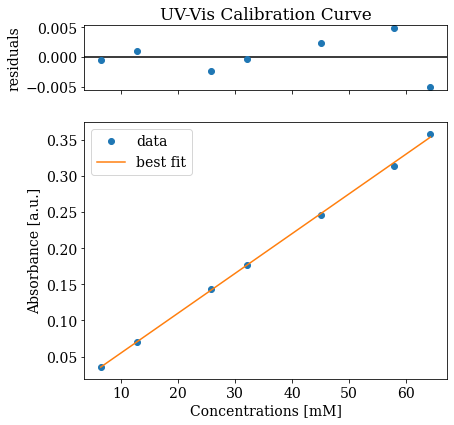

In [ ]:
print("The wavelength used for this fit was {:} nm".format(UV_VisData.beers_find_wavelength(datarange = (550,800))))
UV_result2 = UV_VisData.beerslaw(datarange = (550,800))
display(UV_result2)

Once again, the points with residuals closer to $5*10^{-3}$ are tossed out and the fit is redone only with the points with the residuals closest to $0.000$.

The wavelength used for this fit was 630 nm


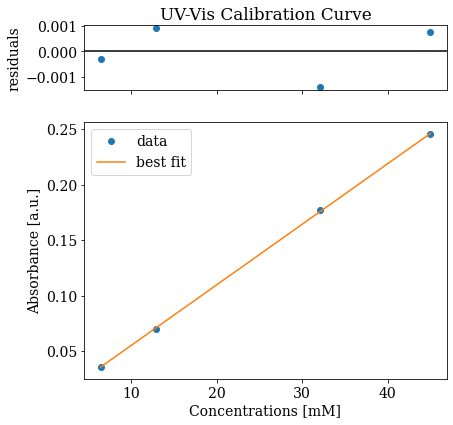

In [ ]:
print("The wavelength used for this fit was {:} nm".format(UV_VisData.beers_find_wavelength(datarange = (550,800))))
UV_result2 = UV_VisData.beerslaw(datarange = (550,800), override = [6.427,12.854,32.135,44.989])
display(UV_result2)

This fit too shows lower residuals and a low chi-squared value. In addition, this fit and the improved fit from the first peak absorbances both show agreement between the data and the line of best fit which suggests that the concentrations found from the line of best fit equation is an accurate indication of the sample measured.

Using the improved fits, the unknown concentration was calculated. For the calculation only the `1/10` and `1/5` dilution ratios were considered, because the absorbance of the undiluted unknown colored solute was >1.2 and therefore it is not considered to be an accurate indication of the concentration within that solute. The slope and y-intercepts of the fits are printed along with their uncertainties below.

In [ ]:
dil_concs_color1, concs_color1 = UV_VisData.find_unknown_conc(UV_result1)
dil_concs_color2, concs_color2 = UV_VisData.find_unknown_conc(UV_result2)
print("The concentrations found from curve of the peaks in the 400-550nm range were (in mM): ")
print(concs_color1)
print("The concentrations found from curve of the peaks in the 550-800nm range were (in mM): ")
print(concs_color2)

The slope of the calibration curve is 0.0062 +/- 0.0000 [A/mM]
The y-int of the calibration curve is 0.0008 +/- 0.0010 [A]
The slope of the calibration curve is 0.0055 +/- 0.0000 [A/mM]
The y-int of the calibration curve is 0.0005 +/- 0.0012 [A]
The concentrations found from curve of the peaks in the 400-550nm range were (in mM): 
[237.92318731182922, 236.677284587185, 237.54738807889132, 241.92623982179285, 249.20798819806015, 249.6282142252523]
The concentrations found from curve of the peaks in the 550-800nm range were (in mM): 
[270.8588320222165, 269.4404593086392, 270.43101099956436, 275.4160260461486, 283.7057849492624, 284.1841827556999]


There seems to be a deviation from the concentrations found from the absorbance at the peak at 415nm and the concentrations found from the absorbance at the peak at 630nm. The averages found for the two peaks are as follows:

In [ ]:
print("The average concentration found from the 415nm peak was (in mM): {:0.4f} +/- {:0.4f}".format(np.mean(concs_color1),np.std(concs_color1)))
print("The average concentration found from the 630nm peak was (in mM): {:0.4f} +/- {:0.4f}".format(np.mean(concs_color2),np.std(concs_color2)))

The average concentration found from the 415nm peak was (in mM): 242.1517 +/- 5.3974
The average concentration found from the 630nm peak was (in mM): 275.6727 +/- 6.1445


Because the two peaks could be indicative of two components within the colored solute contributing to peaks in the UV-Vis spectrum, neither average can be considered a more accurate representation of the concentration over the over. Therefore, the overall average is taken.

In [ ]:
concs_all = concs_color1 + concs_color2
print("The overall average concentration found was (in mM): {:0.4f} +/- {:0.4f}".format(np.mean(concs_all),np.std(concs_all)))

The overall average concentration found was (in mM): 258.9122 +/- 17.7301


In doing the overall average, the standard deviation in the concentration increased greatly and the concentration of the colored solute was found to be 258.91mM. The uncertainty in this value comes from the difference in the slope between the peak analyzed at 415nm and the peak analyzed at 630nm. The uncertainty shown above is the standard deviation from all of the found concentrations at both peaks at both dilution factors, taking the dilution into account.

# Using Fluorimetry to Identify the Unknown Concentration of a Fluorescent Solute:

The fluorimeter data is inputted manually from the numbers written done in the lab notebook during the lab. The fluorescent solute of known concentration data was inputted as a list of the known concentrations `known_concs` in ppm and the corresponding fluorescences `known_fluors`. The fluorescent solute of unknown concentrations was inputted as a list of the dilution factors used `unknown_dils` where 1 indicates that the sample is undiluted and a list of corresponding fluorescences `unknown_fluors`.

In [ ]:
known_concs = [4.53,3.40,2.83,2.26,1.13]
known_fluors = [681.6,503.6,368.7,243.2,99.3]
unknown_dils = [1,1,1,1]
unknown_fluors = [530.2,531.4,538.0,548.1]

The data is loaded into a `FluorimetryData` object.

In [ ]:
FluorData = FluorimetryData(known_concs, known_fluors, unknown_dils, unknown_fluors)

The `fluor_result()` function of the `FluorimetryData` object is used to fit the fluorescences of the fluorescent solute of known concentration is plotted against the concentration and fitted to a line.

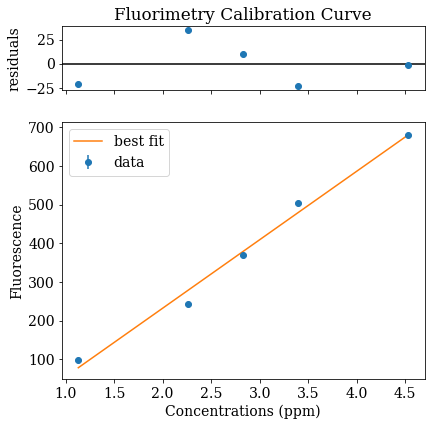

In [ ]:
fluorescence_result = FluorData.fluor_result()
display(fluorescence_result)

The residuals are once again considered and the two points with the highest residuals are tossed out. The three points with the lowest residuals are then used to refit the model.

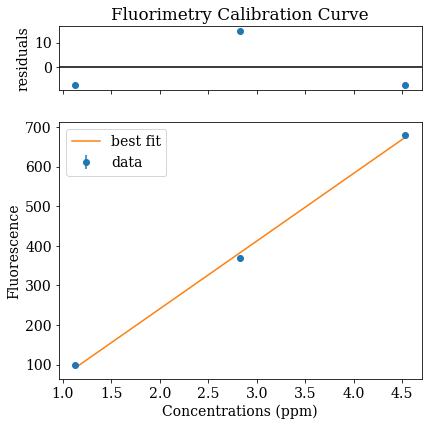

In [ ]:
overridedict = {"Concentration (ppm)":[4.53,2.83,1.13], "Fluorescence":[681.6,368.7,99.3]}
fluorescence_result = FluorData.fluor_result(override = overridedict)
display(fluorescence_result)

While the residuals are still on the order of 0-10, they are improved from the first fit so the concentration found from this fit will be more accurate. The chi-squared value is also lower in this fit yet it is still fairly high which puts a level of uncertainty on the found concentrations from the line of best fit. Still, the mean concentration and its standard deviation are calculated from each of the unknown fluorescences. These are then printed below the slope and y-intercept of the graph and their corresponding uncertainties.

In [ ]:
mean_conc_fluor, sd_conc_fluor = FluorData.find_unknown(fluorescence_result)

The slope of the calibration curve is 171.2647 +/- 7.3867 [A/mM]
The y-int of the calibration curve is -101.4791 +/- 23.2834 [A]
The mean concentration for the unknown was 3.7276 +/- 0.0415 ppm


The concentration of the fluorescent solute of unknown concentration was thus calculated to be 3.728ppm, which is expected because its fluorescence was only slightly greater than that of the 3.40ppm dilution of the known concentration sample without any dilution whatsoever.

# Using FTIR to Identify the Chemical Composition of Unknown Compounds

## Identifying an Unknown Polymer Film

The FTIR spectra for the polymer film are loaded into `InfraredData()` objects and plotted. Two views were taken in case the sample was birefringement.

In [ ]:
filmData_1 = InfraredData()
filmData_1.read_csv(FTIR_files + 'Polymer Film View 1 (Transmittance) Adjusted.csv')
filmData_2 = InfraredData()
filmData_2.read_csv(FTIR_files + 'Polymer Film View 2 (Transmittance) Adjusted.csv')

In [ ]:
filmData_1.baseline_correct()
filmData_1.plot()

In [ ]:
filmData_2.plot()

The spectra for this film don't seem to be very indicative of any particular match as there were very small peaks in a small number of regions. Regardless, the spectra are searched using KnowItAllAnyware and specified to search for polymers, as it is known that it is a polymer. The closest match to both spectra on observation and percent match was poly(vinyl phosphate) with a $75.98\%$ match. The picture of the match with one of the transmittance spectra is displayed below.

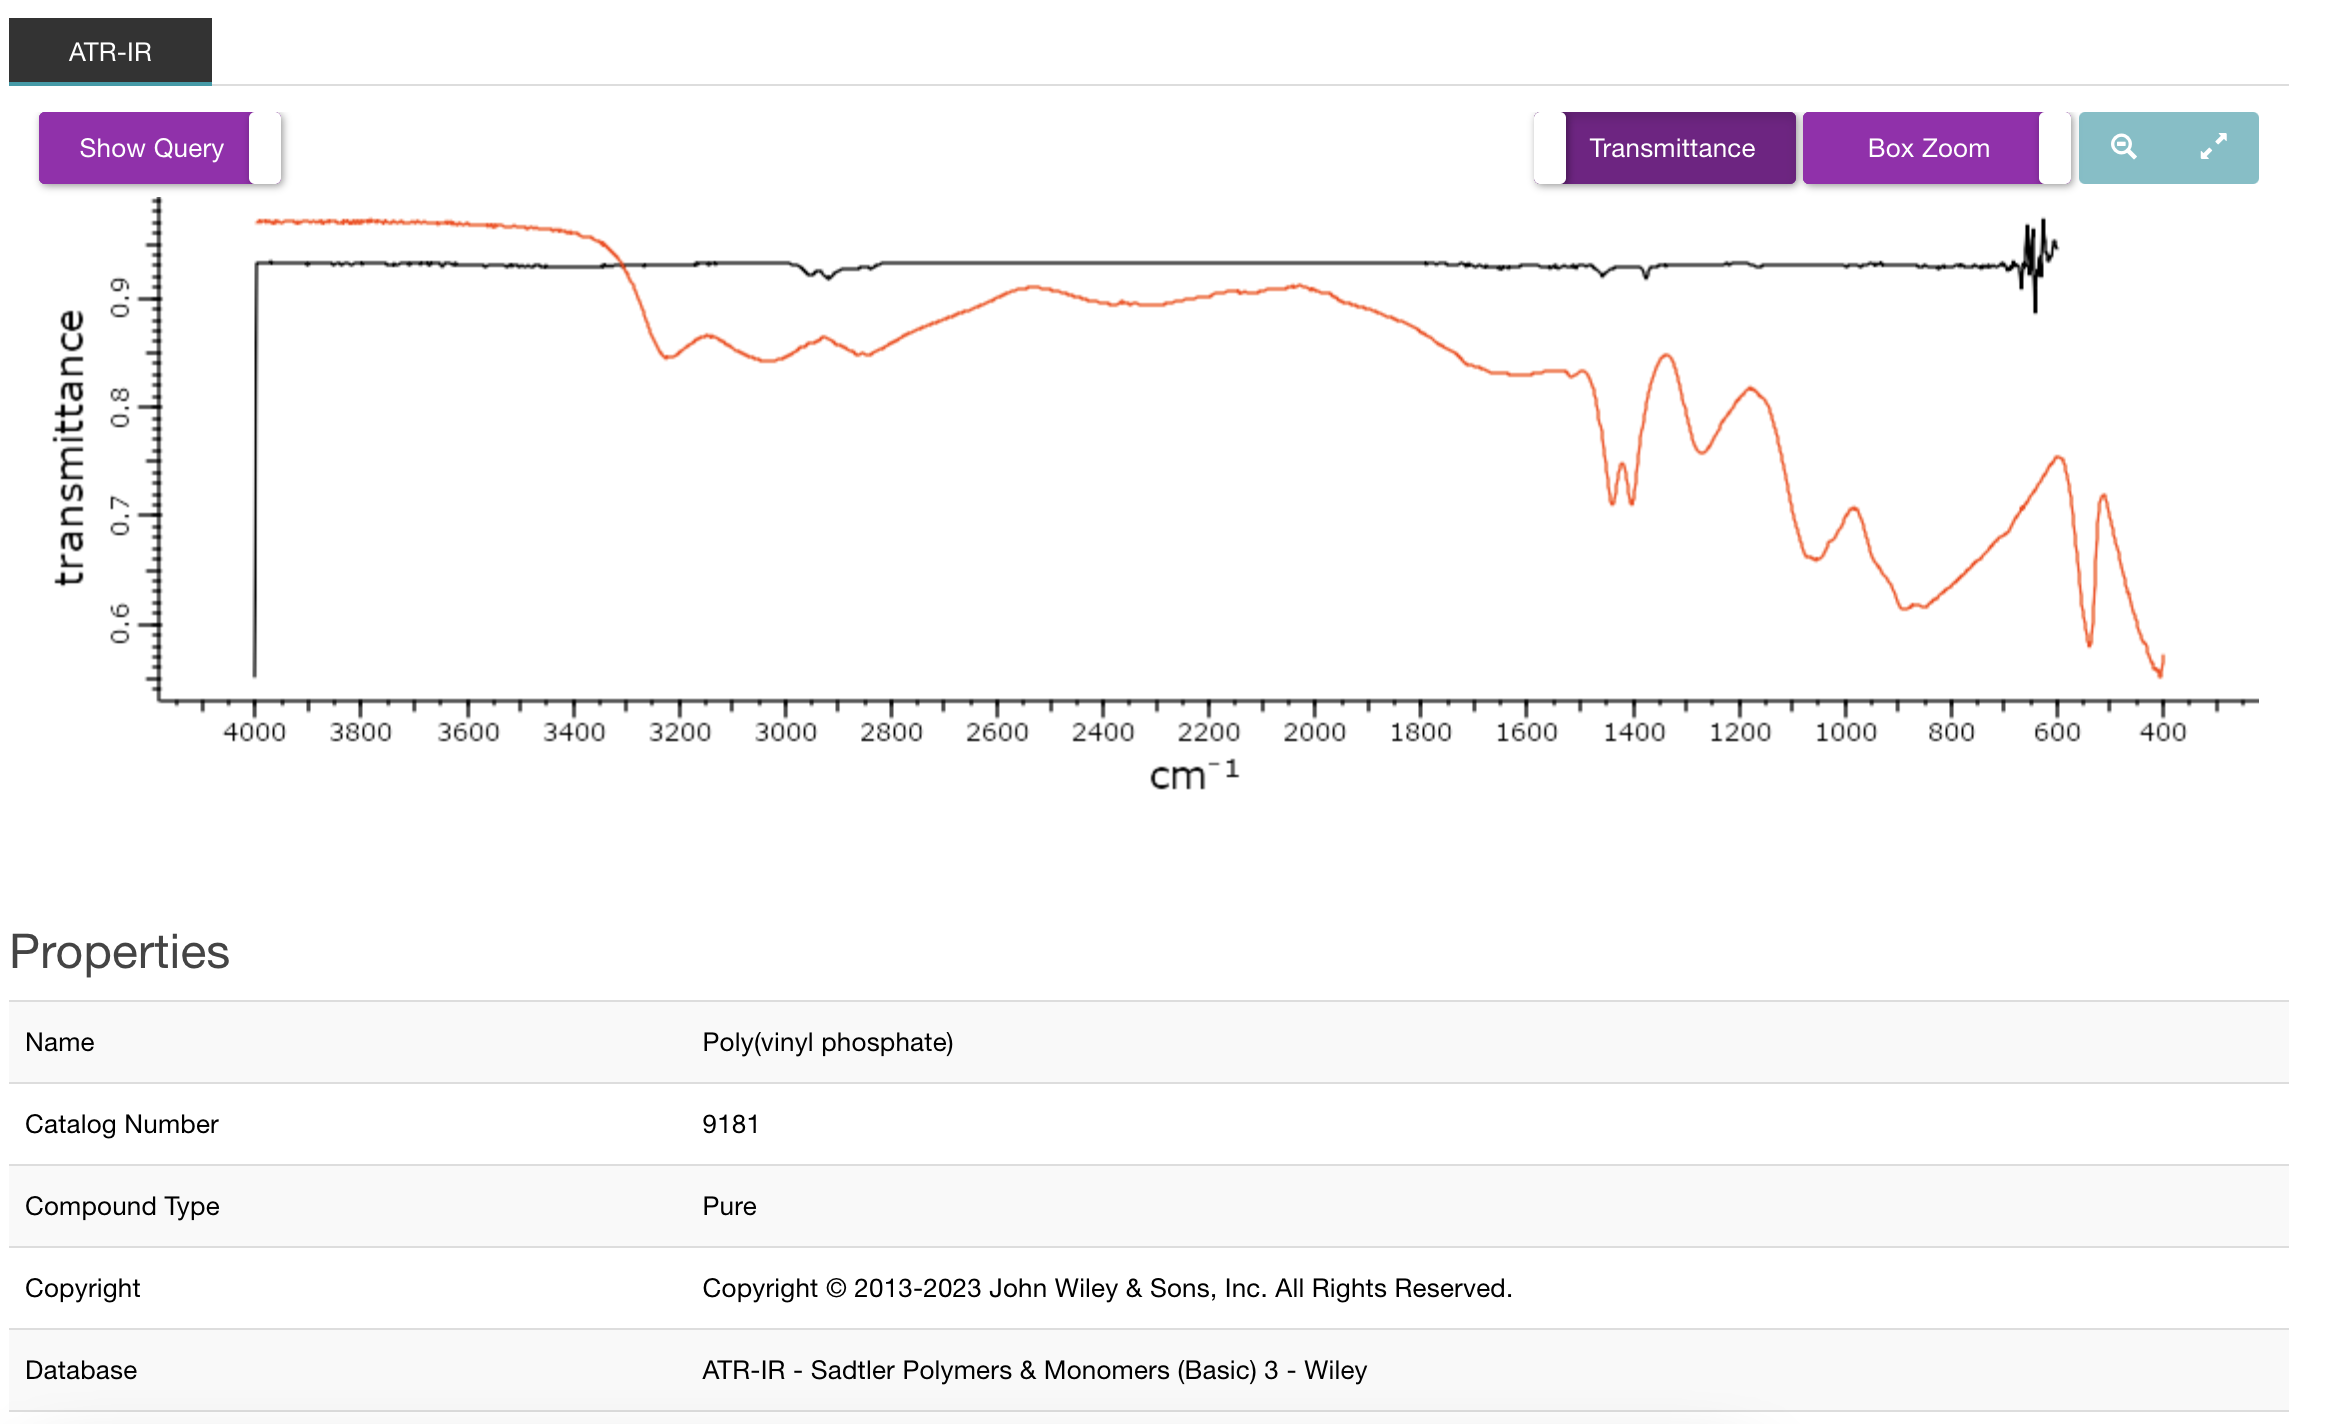

Obviously, observing the search, the spectra don't particularly match well. There are slight peaks on the analyzed sample (black) where there are major peaks in the poly(vinyl phosphate) spectra (red) between $3000-2800cm^{-1}$ and $1500-1400cm^{-1}$. Hence, it can be said that the film could be poly(vinyl phosphate), but there is not very much confidence to back the match.

## Identifying an Unknown Powder

The FTIR spectra for the unknown powder are uploaded into `InfraredData()` objects. Two spectra are uploaded, one being the original spectrum of the powder and the other being the spectrum that resulted from subtracting the highest match to the powder, which was Dextrose anhydrous powder in KBr with an $88.56\%$ match from the Georgia State Crime Lab Sample Library, having searched all spectral libraries available on the OMNIC software.

In [ ]:
powderData = InfraredData()
powderData.read_csv(FTIR_files + 'powdersample.CSV')
subtractData = InfraredData()
subtractData.read_csv(FTIR_files + 'Subtraction Result-@powdersample.CSV')

The original (as in unsubtracted) spectrum of the unknown powder is plotted.

In [ ]:
powderData.baseline_correct()
powderData.plot()

The spectrum for Dextrose Anhydrous powder in KBr, found on KnowItAll Anyware, is inserted to verify the match.

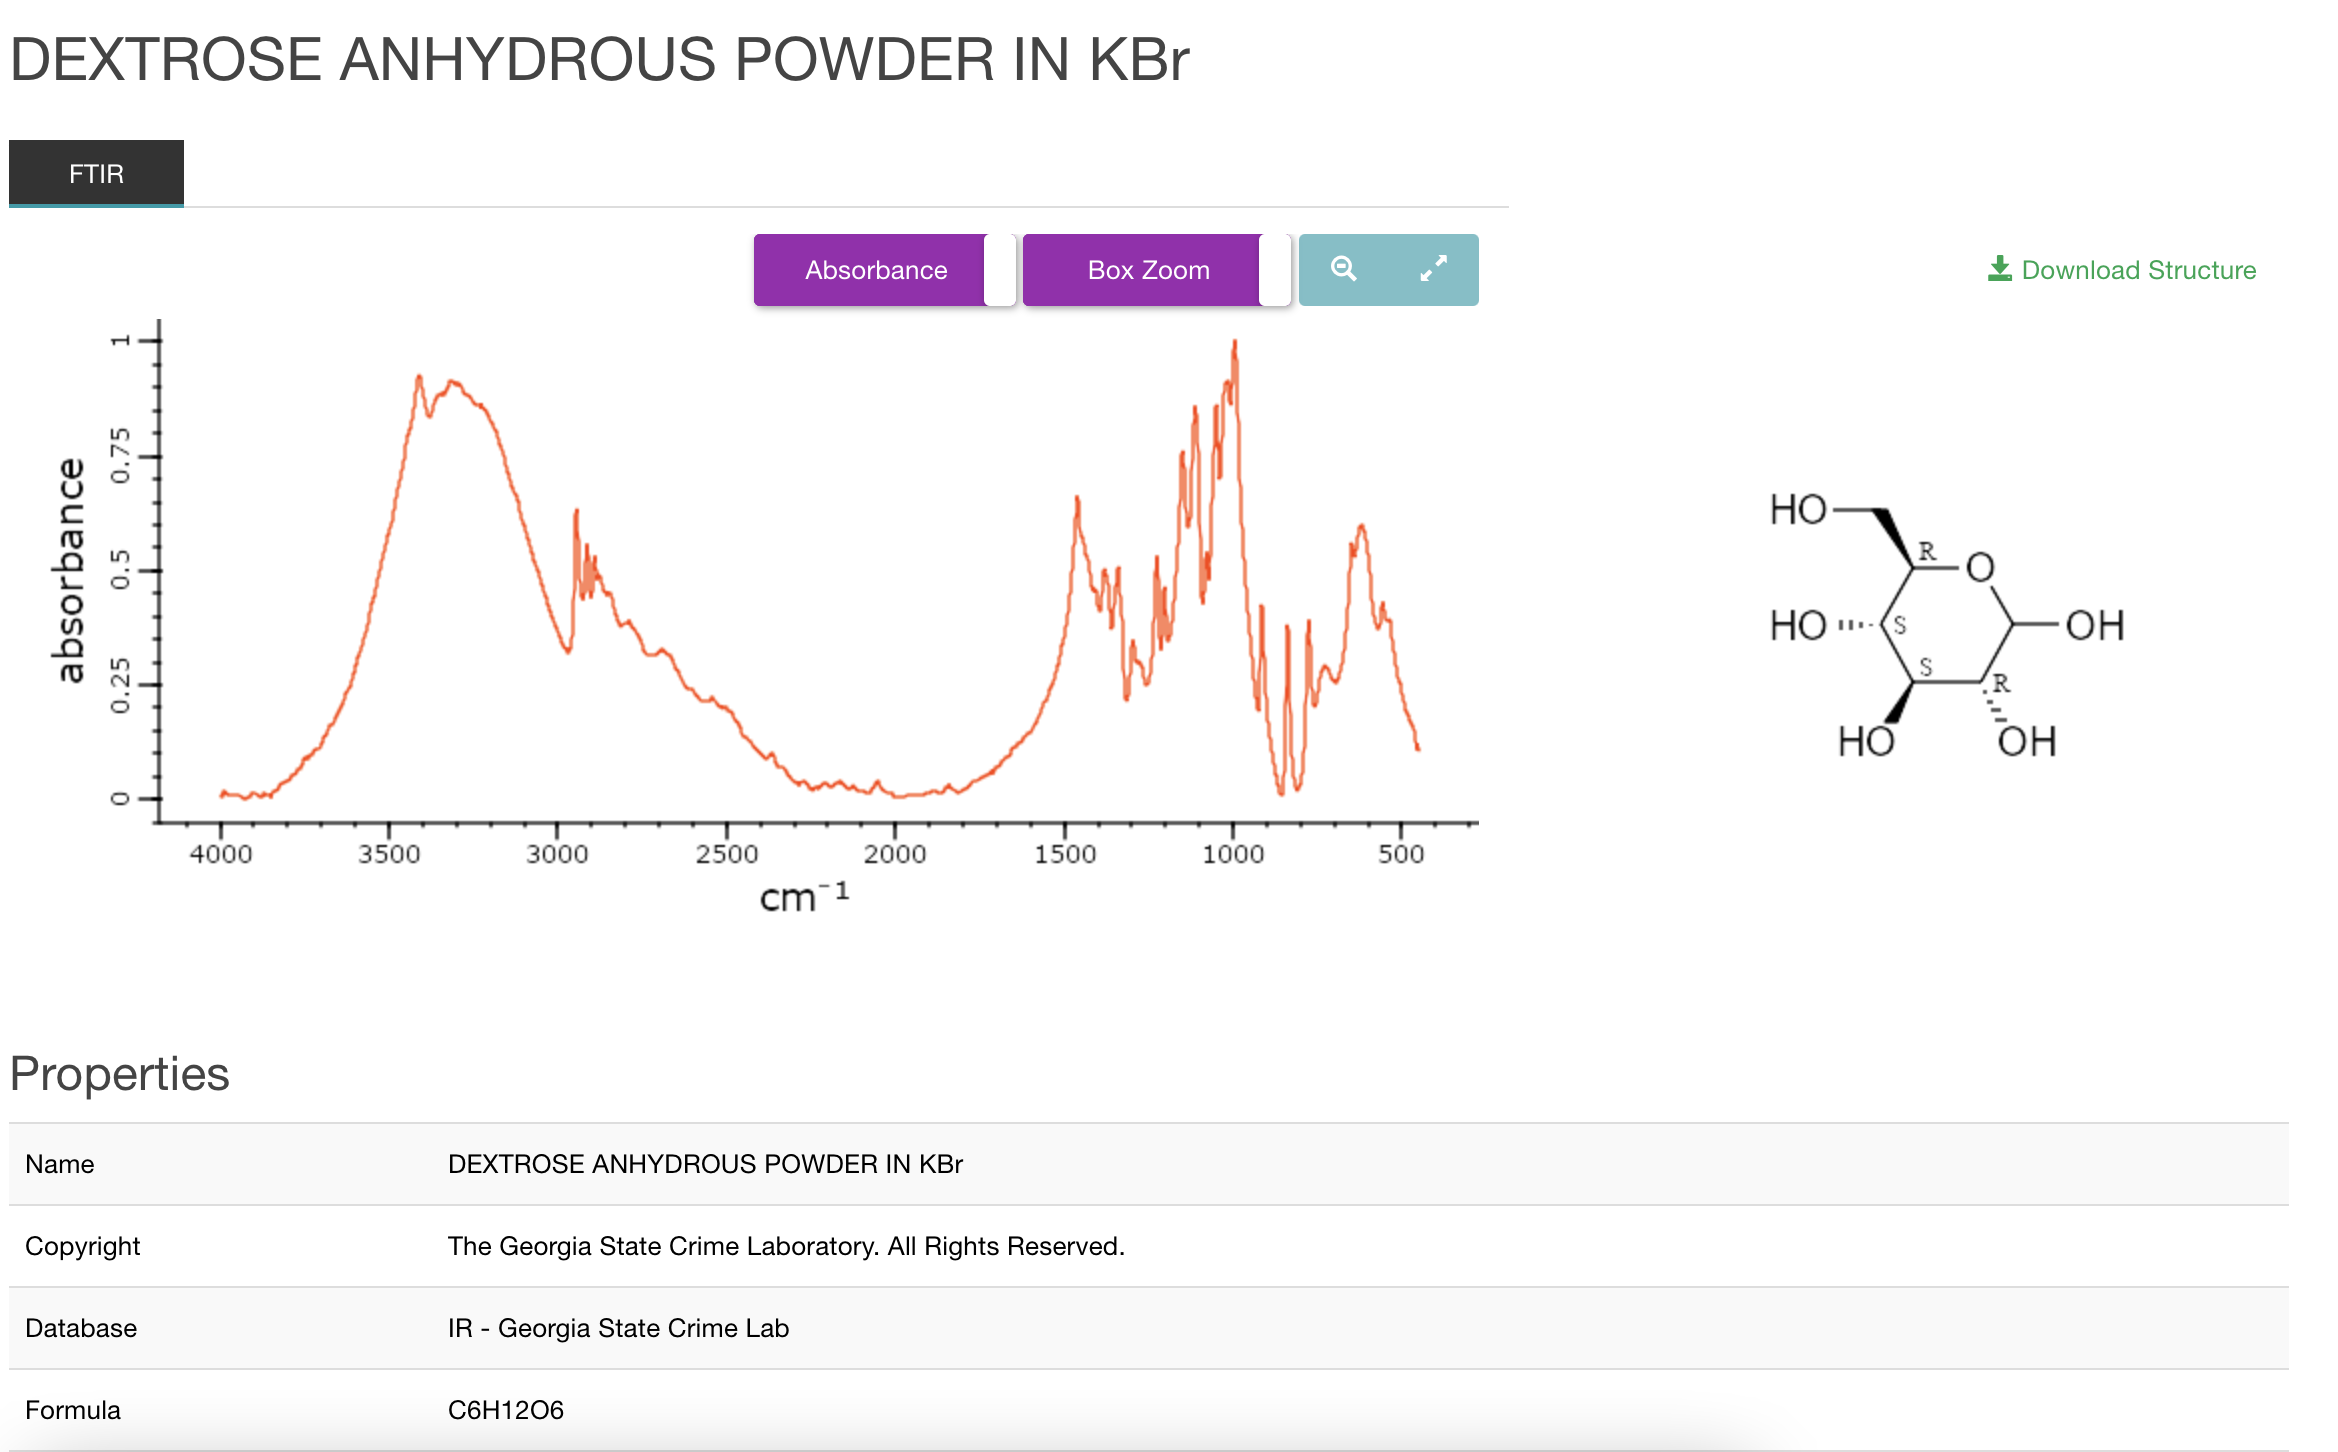

Observing the unknown powder spectrum and the dextrose anhydrous powder spectrum, it can be concluded that the unknown powder was or at least contained predominantly Dextrose Anhydrous Powder in KBr, given also the high percentage match ($88.56\%$) as indicated by the Georgia State Crime Lab Sample Library.

The Dextrose anydrous powder spectrum was subtracted from the unknown powder spectrum to determine whether there were other components in the unknown powder. The subtracted spectrum is plotted below.

In [ ]:
subtractData.baseline_correct()
subtractData.plot()

Searching this spectrum in KnowItAll Anyware did not yield any good matches, which would indicate that there is not another component to the unknown powder. As such, it is concluded that the unknown powder was Dextrose Anydrous Powder.

# References

$^1$Marohn, J. A. (n.d.). CHEM-3020-FA-2022--shared. Google Drive.

$^2$Modeling data and curve fitting¶. Modeling Data and Curve Fitting - Non-Linear Least-Squares Minimization and Curve-Fitting for Python. (n.d.). Retrieved December 2, 2022, from https://lmfit.github.io/lmfit-py/model.html

$^3$Engineering tables/chi-squared distribution. Wikibooks, open books for an open world. (n.d.). Retrieved December 1, 2022, from https://en.wikibooks.org/wiki/Engineering_Tables/Chi-Squared_Distribution